In [206]:
import pandas as pd
import missingno.missingno as msn

import numpy as np
import pulp
from pulp import LpMinimize, LpProblem, LpVariable
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(11.7,8.27)})

import networkx as nx
import pickle

# Load Data

In [207]:
electicify_df = pd.read_csv('API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_4695288.csv',skiprows=4)
electicify_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.794160,32.001027,33.871910,38.880173,40.261358,43.061877,44.270860,45.803485,NaN,NaN
2,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,68.290649,89.500000,71.500000,97.699997,97.699997,96.616135,97.699997,97.699997,NaN,NaN
3,Africa Western and Central,AFW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,47.048316,47.599323,46.766294,50.953487,48.861191,51.259712,51.290193,52.111601,NaN,NaN
4,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.278030,32.000000,42.000000,41.813129,43.013260,45.290001,45.642799,46.890610,NaN,NaN


In [208]:
electicify_df.isna().sum().sort_values()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
2019                2
                 ... 
1985              266
1986              266
1987              266
1974              266
Unnamed: 66       266
Length: 67, dtype: int64

In [209]:
finance_df = pd.read_excel('IRENA_RE_Public_Investment_July2022.xlsx')
finance_df.head()

,ISO-code,Country/Area,Region,Project,Donor,Agency,Year,Category,Technology,Sub-technology,Finance Group,Finance Type,Source,Reference Date,Amount (2020 USD million)
0,EUE,European Union (27),Europe,SOLAS SUSTAINABLE ENERGY FUND,EU Institutions,European Investment Bank,2020,Renewables,Multiple renewables,Multiple renewables,Equity,Shares in collective investment vehicles,https://www.eib.org/en/projects/loans/all/2018...,2020-12-17,0.583190
1,EUE,European Union (27),Europe,Taaleri Energia Solarwind Fund II,EU Institutions,European Investment Bank,2019,Renewables,Multiple renewables,Multiple renewables,Equity,Shares in collective investment vehicles,https://www.eib.org/en/projects/loans/all/2018...,2019-06-06,4.882124
2,EUE,European Union (27),Europe,MERIDIAM GREEN IMPACT GROWTH FUND (GIGF),EU Institutions,European Investment Bank,2020,Renewables,Multiple renewables,Multiple renewables,Equity,Shares in collective investment vehicles,https://www.eib.org/en/projects/loans/all/2019...,2020-12-07,0.680388
3,EUE,European Union (27),Europe,SMALL-SCALE SOLAR PROGRAM IN SSA,EU Institutions,European Investment Bank,2020,Renewables,Solar energy,Off-grid Solar photovoltaic,Debt,Standard loan,https://www.eib.org/en/projects/loans/all/2019...,2020-12-04,0.777586
4,EUE,European Union (27),Europe,ITALIAN ENERGY EFFICIENCY FUND II,EU Institutions,European Investment Bank,2020,Renewables,Multiple renewables,Multiple renewables,Equity,Shares in collective investment vehicles,https://www.eib.org/en/projects/loans/all/2019...,2020-08-06,0.155517


In [210]:
country_df = pd.read_csv('Metadata_Country_API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_4695288.csv')
country_df.head()

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


# FILTERING DATA
#### only sub sahara

In [211]:
subSahara_code = country_df[country_df.Region == "Sub-Saharan Africa"]
subSahara_code.shape
subSahara_code.to_csv('list_subSahara.csv')

In [212]:
electicify_df = electicify_df[electicify_df['Country Code'].isin(subSahara_code['Country Code'].to_list())]
print(electicify_df.shape)
electicify_df.head()

(48, 67)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
4,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.278030,32.000000,42.000000,41.813129,43.013260,45.290001,45.642799,46.890610,NaN,NaN
16,Burundi,BDI,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.900000,7.000000,8.427652,9.348410,9.300000,10.884909,11.356528,11.735556,NaN,NaN
18,Benin,BEN,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,34.691219,34.099998,29.620001,37.095245,34.500000,39.246918,40.328690,41.410957,NaN,NaN
19,Burkina Faso,BFA,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,15.405643,19.200001,16.076975,16.641056,17.214043,14.400000,18.374855,18.957239,NaN,NaN
33,Botswana,BWA,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,57.991920,59.952995,62.130001,64.175056,67.400002,68.229263,69.959740,71.994759,NaN,NaN


In [213]:
finance_df = finance_df[finance_df['ISO-code'].isin(subSahara_code['Country Code'].to_list())]
print(finance_df.shape)
finance_df.head()

(3525, 15)


,ISO-code,Country/Area,Region,Project,Donor,Agency,Year,Category,Technology,Sub-technology,Finance Group,Finance Type,Source,Reference Date,Amount (2020 USD million)
880,AGO,Angola,Africa,TC AGGREGATED ACTIVITIES,Japan,Japanese International Co-operation Agency,2018,Renewables,Multiple renewables,Multiple renewables,Grants,Standard grant,2018 OECD Credit Report System (CRS) Database,2018-12-31,0.010968
881,AGO,Angola,Africa,loan to Sonangol,China,China Development Bank,2013,Non-renewables,Oil,Oil,Debt,Standard loan,"Gallagher, Kevin P. (2021), “China’s Global En...",2013-01-01,1314.902373
882,AGO,Angola,Africa,POWER GENERATION,Italy,Central administration,2004,Non-renewables,Fossil fuels n.e.s.,Fossil fuels n.e.s.,Grants,Standard grant,2004-05 OECD Credit Report System (CRS) Database,2004-01-01,0.038248
883,AGO,Angola,Africa,Unspecified Oil Export,China,China Development Bank,2014,Non-renewables,Oil,Oil,Debt,Standard loan,"Gallagher, Kevin P. (2021), “China’s Global En...",2014-01-01,1976.056168
884,AGO,Angola,Africa,Unspecified Oil Export,China,China Development Bank,2016,Non-renewables,Oil,Oil,Debt,Standard loan,"Gallagher, Kevin P. (2021), “China’s Global En...",2016-01-01,7250.602922


# Data Preparation

<AxesSubplot:>

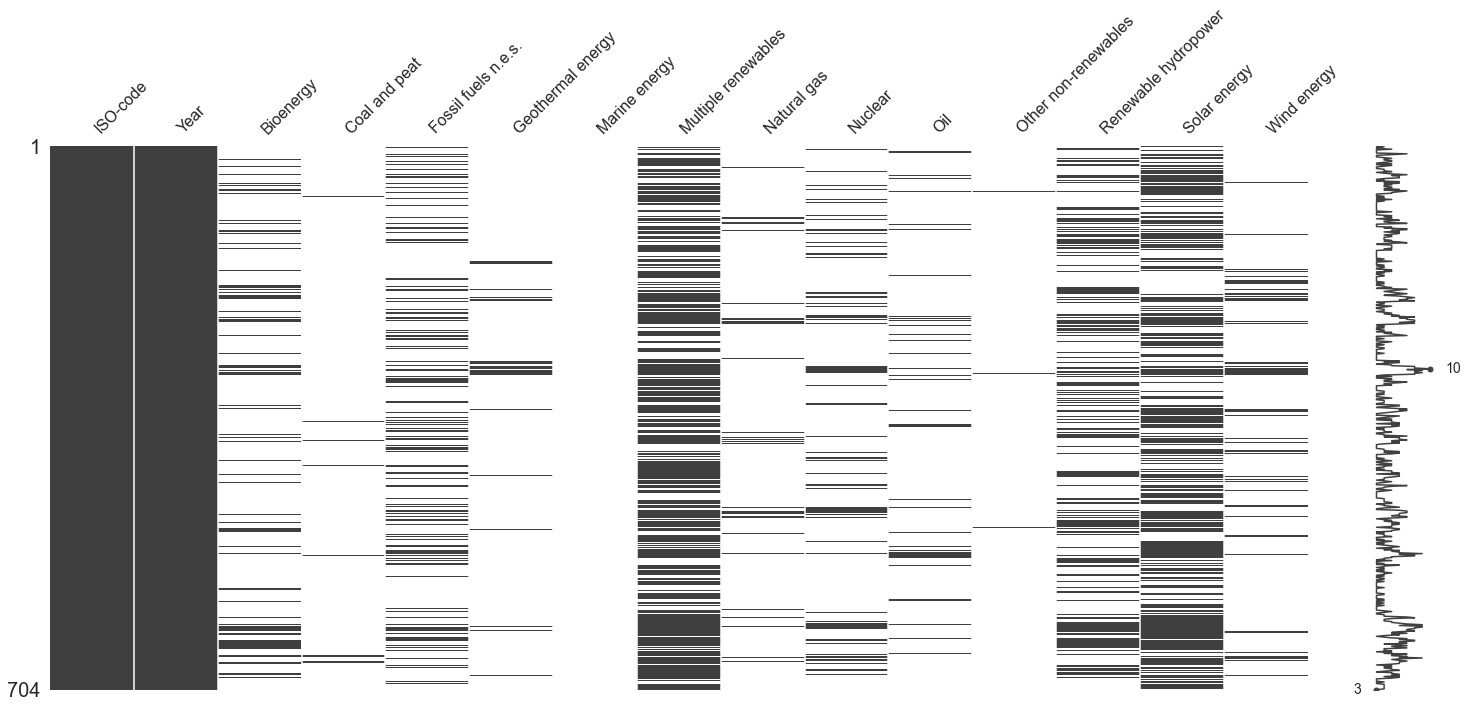

In [214]:
pivot_df = finance_df.pivot_table(index=['ISO-code','Year'], columns='Technology', values='Amount (2020 USD million)', aggfunc='sum').reset_index()
msn.matrix(pivot_df)

In [215]:
pivot_df = pivot_df.fillna(0)
# pivot_df = pivot_df.drop(columns=['Marine energy'])
pivot_df.head()

Technology,ISO-code,Year,Bioenergy,Coal and peat,Fossil fuels n.e.s.,Geothermal energy,Marine energy,Multiple renewables,Natural gas,Nuclear,Oil,Other non-renewables,Renewable hydropower,Solar energy,Wind energy
0,AGO,2003,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.046284,0.0
1,AGO,2004,0.0,0.0,0.038248,0.0,0.0,0.038258,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
2,AGO,2006,0.0,0.0,1.624527,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
3,AGO,2007,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.760908,0.000000,0.0
4,AGO,2010,0.0,0.0,0.000000,0.0,0.0,0.013506,0.0,0.29202,0.0,0.0,0.006694,0.000000,0.0


In [216]:
for country in pivot_df['ISO-code'].unique():
    mask1 = pivot_df['ISO-code'] == country
    for year in range(2000,2021):
        mask2 = pivot_df['Year'] == year
        if len(pivot_df[(mask1)&(mask2)]) == 0:
            pivot_df.loc[len(pivot_df.index)] = [country, year] + [0]*13
            
pivot_df = pivot_df.sort_values(['ISO-code','Year']).reset_index().iloc[:,1:]
# df.groupby('id')['x'].rolling(2).mean()
rolling_df = pivot_df.groupby(['ISO-code'])[pivot_df.columns[2:]].rolling(3).sum().reset_index().dropna()
rolling_df['Year'] = pivot_df['Year']
rolling_df = rolling_df.iloc[pd.np.where(rolling_df[rolling_df.columns[2:-1]].gt(10**-12).any(1))]
print(rolling_df.shape)
rolling_df.head()

(800, 16)


<ipython-input-216-3ac82a4ebfe4>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  rolling_df = rolling_df.iloc[pd.np.where(rolling_df[rolling_df.columns[2:-1]].gt(10**-12).any(1))]


Technology,ISO-code,level_1,Bioenergy,Coal and peat,Fossil fuels n.e.s.,Geothermal energy,Marine energy,Multiple renewables,Natural gas,Nuclear,Oil,Other non-renewables,Renewable hydropower,Solar energy,Wind energy,Year
3,AGO,3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.046284,0.0,2003
4,AGO,4,0.0,0.0,0.038248,0.0,0.0,0.038258,0.0,0.0,0.0,0.0,0.000000,0.046284,0.0,2004
5,AGO,5,0.0,0.0,0.038248,0.0,0.0,0.038258,0.0,0.0,0.0,0.0,0.000000,0.046284,0.0,2005
6,AGO,6,0.0,0.0,1.662775,0.0,0.0,0.038258,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,2006
7,AGO,7,0.0,0.0,1.624527,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.760908,0.000000,0.0,2007


In [217]:
melt_df = electicify_df.iloc[:,:-2].drop(columns=['Country Name', 'Indicator Name','Indicator Code']).fillna(-1).melt(id_vars='Country Code').sort_values(by=['Country Code', 'variable'])
melt_df.head()

,Country Code,variable,value
0,AGO,1960,-1.0
48,AGO,1961,-1.0
96,AGO,1962,-1.0
144,AGO,1963,-1.0
192,AGO,1964,-1.0


In [218]:
melt_df['shift'] = melt_df.value.shift(1)
melt_df['shift_c'] = melt_df['Country Code'].shift(1)
melt_df['delta'] = melt_df.apply(lambda row: row['value']-row['shift'] if row['shift_c'] == row['Country Code'] else -1,axis=1)
melt_df['variable'] = melt_df['variable'].astype('int64')
melt_df.iloc[50:70]

,Country Code,variable,value,shift,shift_c,delta
2400,AGO,2010,34.895638,33.802189,AGO,1.093449
2448,AGO,2011,34.599998,34.895638,AGO,-0.295639
2496,AGO,2012,37.131321,34.599998,AGO,2.531322
2544,AGO,2013,38.278030,37.131321,AGO,1.146709
2592,AGO,2014,32.000000,38.278030,AGO,-6.278030
2640,AGO,2015,42.000000,32.000000,AGO,10.000000
2688,AGO,2016,41.813129,42.000000,AGO,-0.186871
2736,AGO,2017,43.013260,41.813129,AGO,1.200130
2784,AGO,2018,45.290001,43.013260,AGO,2.276741
2832,AGO,2019,45.642799,45.290001,AGO,0.352798


In [219]:
transformed_df = rolling_df.merge(melt_df, left_on=['ISO-code','Year'], right_on=['Country Code', 'variable'])
transformed_df = transformed_df.drop(columns=['Country Code','variable','value','shift','shift_c','level_1'])
transformed_df.to_csv('transformed_df.csv')
transformed_df.sample(10)

,ISO-code,Bioenergy,Coal and peat,Fossil fuels n.e.s.,Geothermal energy,Marine energy,Multiple renewables,Natural gas,Nuclear,Oil,Other non-renewables,Renewable hydropower,Solar energy,Wind energy,Year,delta
787,ZWE,0.0,0.000000,0.046361,0.0,0.0,5.684342e-14,0.0,0.000000e+00,0.000000e+00,0.0,-2.273737e-13,4.990002e-01,0.000000e+00,2007,0.004009
34,BEN,0.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,9.225732e-02,1.421085e-14,0.000000e+00,2003,0.933395
415,MLI,0.0,0.000000,90.068286,0.0,0.0,5.895245e-01,0.0,0.000000e+00,0.000000e+00,0.0,3.780854e+01,1.822613e-01,0.000000e+00,2009,0.620289
418,MLI,0.0,28.696612,21.233490,0.0,0.0,1.785030e-01,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,2.481353e-01,0.000000e+00,2012,-3.084454
272,GIN,0.0,0.000000,2.647402,0.0,0.0,2.491672e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2006,2.596291
180,COM,0.0,0.000000,0.000000,0.0,0.0,4.445511e-02,0.0,0.000000e+00,0.000000e+00,0.0,1.115409e+01,1.388046e-01,-1.387779e-17,2018,2.435905
448,MRT,0.0,0.000000,30.956818,0.0,0.0,5.684342e-14,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-1.421085e-14,0.000000e+00,2004,1.366631
38,BEN,0.0,0.000000,3.842012,0.0,0.0,8.537802e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.421085e-14,0.000000e+00,2007,0.178017
380,LSO,0.0,0.000000,0.000000,0.0,0.0,4.626341e-02,0.0,0.000000e+00,0.000000e+00,0.0,1.814123e-01,2.842484e+00,0.000000e+00,2012,-1.845442
666,SWZ,0.0,0.000000,0.000000,0.0,0.0,1.183330e+01,0.0,2.220446e-16,2.842171e-14,0.0,0.000000e+00,1.506746e+00,0.000000e+00,2020,2.861061


In [220]:
technology_list = finance_df.drop_duplicates(['Technology', 'Category']).sort_values(['Category'])[['Technology', 'Category']]
technology_list

,Technology,Category
881,Oil,Non-renewables
882,Fossil fuels n.e.s.,Non-renewables
892,Nuclear,Non-renewables
911,Natural gas,Non-renewables
977,Coal and peat,Non-renewables
1012,Other non-renewables,Non-renewables
880,Multiple renewables,Renewables
886,Solar energy,Renewables
899,Renewable hydropower,Renewables
900,Bioenergy,Renewables


In [221]:
filter_df = transformed_df[technology_list.loc[technology_list.Category == 'Renewables','Technology'].to_list()+['delta']]
filter_df = filter_df.drop(columns=['Marine energy'])
filter_df.head()

,Multiple renewables,Solar energy,Renewable hydropower,Bioenergy,Wind energy,Geothermal energy,delta
0,0.000000,0.046284,0.000000,0.0,0.0,0.0,1.060659
1,0.038258,0.046284,0.000000,0.0,0.0,0.0,1.057774
2,0.038258,0.046284,0.000000,0.0,0.0,0.0,1.057236
3,0.038258,0.000000,0.000000,0.0,0.0,0.0,1.059109
4,0.000000,0.000000,0.760908,0.0,0.0,0.0,6.913105


# Analysis
#### Values Transform

In [222]:
x_raw = filter_df.iloc[:,:-1]
y_raw = y = filter_df.delta

array([[<AxesSubplot:title={'center':'Multiple renewables'}>,
        <AxesSubplot:title={'center':'Solar energy'}>],
       [<AxesSubplot:title={'center':'Renewable hydropower'}>,
        <AxesSubplot:title={'center':'Bioenergy'}>],
       [<AxesSubplot:title={'center':'Wind energy'}>,
        <AxesSubplot:title={'center':'Geothermal energy'}>]], dtype=object)

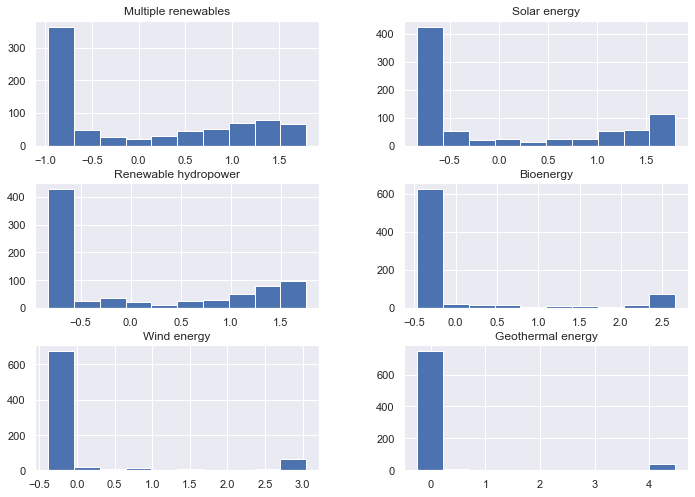

In [223]:
x_transformer = PowerTransformer()
x = pd.DataFrame(x_transformer.fit_transform(x_raw), columns= x_raw.columns)
x.hist()

[Text(0.5, 0, 'Correlation to Electrification Increase'),
 Text(0, 0.5, 'Renewable Technologies')]

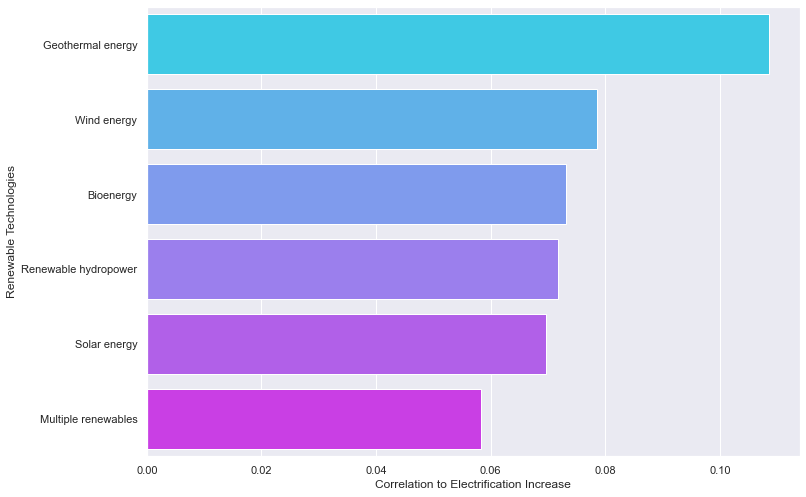

In [224]:
a = x.copy()
a['Y'] = y
a = a.corr().Y.iloc[:-1]
ax = sns.barplot(data = a.reset_index().sort_values('Y',ascending=False), x='Y', y='index', palette='cool', orient='h')
ax.set(xlabel='Correlation to Electrification Increase', ylabel='Renewable Technologies')

#### Outliers handling

In [225]:
X_lm = x.copy()
X_lm = sm.add_constant(X_lm)
model = sm.OLS(y, X_lm).fit() 

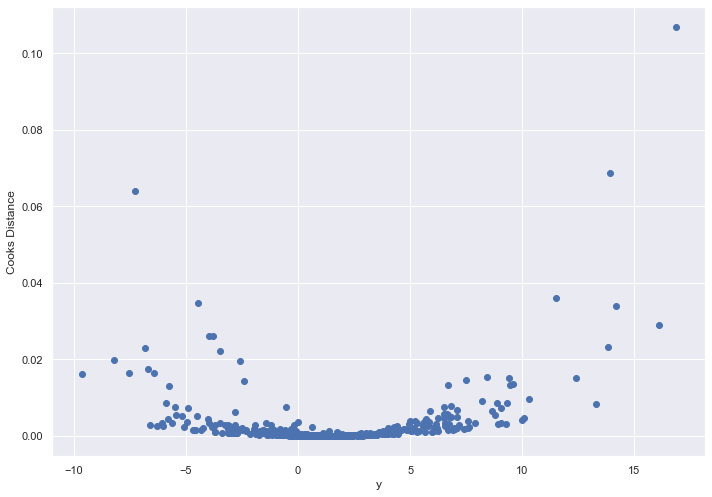

In [226]:


#create instance of influence
influence = model.get_influence()
cooks = influence.cooks_distance


plt.scatter(y, cooks[0])
plt.xlabel('y')
plt.ylabel('Cooks Distance')
plt.show()

<AxesSubplot:>

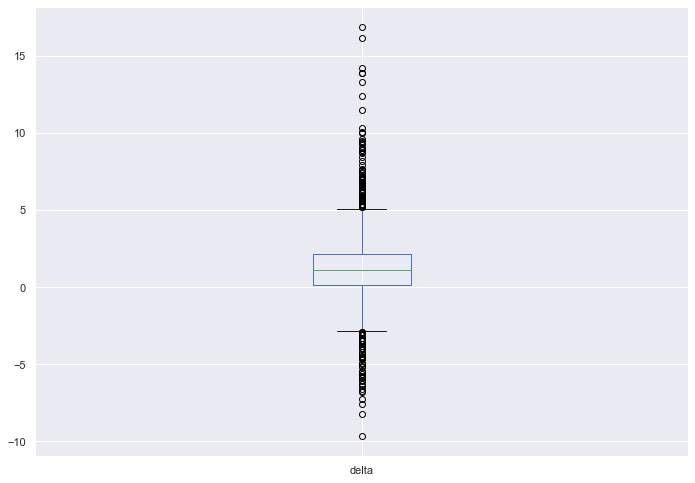

In [227]:
y.plot.box()

In [228]:
# filter out
# outliers = (cooks[0] >= 0.1) | (y > 3)
outliers = cooks[0] >= 0.01
X = x[~outliers]
Y = y[~outliers]
X.columns = x.columns

X_cv = x_raw[~outliers]
Y_cv = y_raw[~outliers]

<AxesSubplot:>

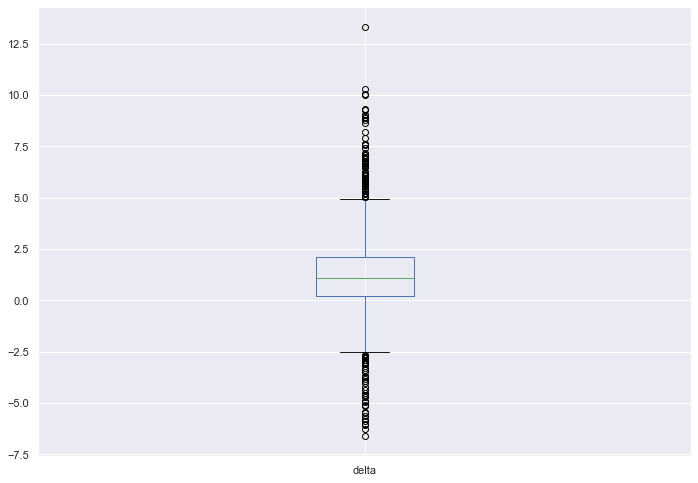

In [229]:
Y.plot.box()

# Modelling

In [230]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [231]:
models = {'RLM':Ridge(),
          "DT": DecisionTreeRegressor(),
          'KNN': KNeighborsRegressor(),
          'RF': RandomForestRegressor()
          }

for name, model in models.items():
    pipe = make_pipeline(PowerTransformer(), model)
    score = cross_validate(model, X_cv, Y_cv, cv=10, scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])
    mae = -score['test_neg_mean_absolute_error'].mean()
    rmse = -score['test_neg_root_mean_squared_error'].mean()
    print (name, "10Fold-MAE :", mae, ", 10Fold-RMSE :", rmse)

RLM 10Fold-MAE : 1.7074549836416382 , 10Fold-RMSE : 2.472644310006672
DT 10Fold-MAE : 2.65149816145357 , 10Fold-RMSE : 3.5873514856431514
KNN 10Fold-MAE : 1.9495288371190285 , 10Fold-RMSE : 2.6633464323030864
RF 10Fold-MAE : 1.8486675937326325 , 10Fold-RMSE : 2.577942521373654


### Ridge LM

In [232]:
model = Ridge()
params = {'alpha':[i for i in range(3000)],
         }

grid_cv = GridSearchCV(model,params,cv=10, scoring='neg_root_mean_squared_error', verbose=1)
pipe = make_pipeline(PowerTransformer(), grid_cv)
pipe.fit(X_cv,Y_cv)
grid_result = pipe.get_params()['steps'][1][1]
print('best score:',grid_result.best_score_)
grid_result.best_params_

Fitting 10 folds for each of 3000 candidates, totalling 30000 fits
best score: -2.40842704475328


{'alpha': 462}

In [241]:
# fitting final model
alpha = 462
linear_model = Ridge(alpha=alpha)
# linear_model.fit(X_transform,Y)
linear_model.fit(X,Y)

Ridge(alpha=462)

R2 0.01933105328538165 
RMSE 2.456565908176348 
MAE 1.6271748994905815


<AxesSubplot:xlabel='predict', ylabel='error'>

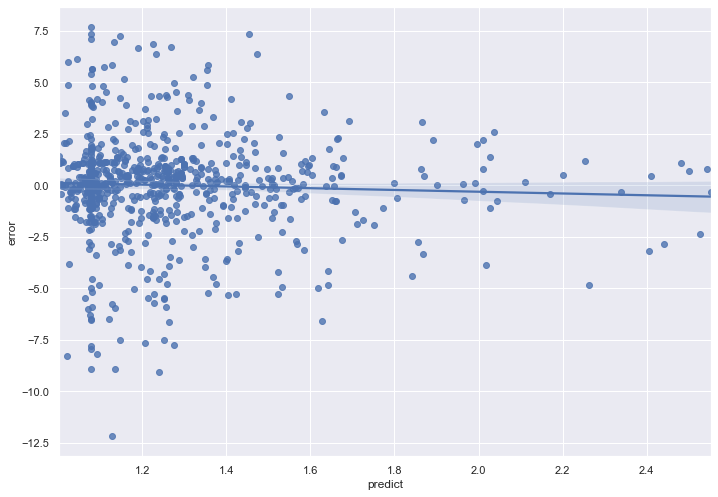

In [242]:
lm = pd.DataFrame({'predict': linear_model.predict(X), 'true':Y})
lm['error'] = lm['predict'] - lm['true']
plot_df = lm.copy().sort_values(['error']).reset_index()
print('R2', r2_score(lm['true'],lm['predict']),
      '\nRMSE', mean_squared_error(lm['true'],lm['predict'],squared=False),
      '\nMAE', mean_absolute_error(lm['true'],lm['predict']))
sns.regplot(x = 'predict' , y = 'error', data = plot_df, scatter = True)

<AxesSubplot:>

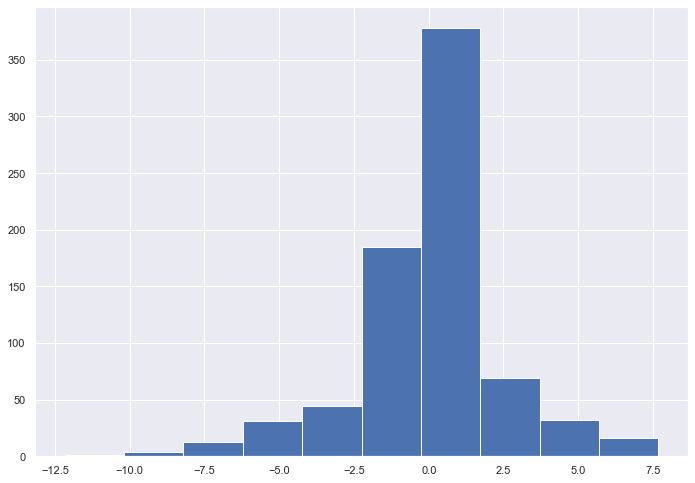

In [243]:
plot_df.error.hist()

### Random Forest

In [244]:
model = RandomForestRegressor()
params = {'n_estimators':[i for i in range(5,16,5)], # ga terlalu banyak, biar mengurangi kompleksitas analisis rules
          'max_depth':[i for i in range(4,8)], # berpengaruh ke jumlah rules tiap tree
          'min_samples_split': [0.1,0.05,0.01,2,4,6] # pruning pada tree yang telah dibuat
         }
grid_cv = GridSearchCV(model,params,cv=10, scoring='neg_root_mean_squared_error', verbose=1)
pipe = make_pipeline(PowerTransformer(), grid_cv)
pipe.fit(X_cv,Y_cv)
grid_result = pipe.get_params()['steps'][1][1]
print('best RMSE score:',grid_result.best_score_)
grid_result.best_params_

Fitting 10 folds for each of 72 candidates, totalling 720 fits
best RMSE score: -2.4188472765492524


{'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 15}

In [245]:
# fitting final model
rf_model = RandomForestRegressor(n_estimators=15, min_samples_split=4, max_depth=4)
rf_model.fit(X,Y)

RandomForestRegressor(max_depth=4, min_samples_split=4, n_estimators=15)

R2 0.1031336545010697 
RMSE 2.349259937343006 
MAE 1.5585792229392645


<AxesSubplot:xlabel='predict', ylabel='error'>

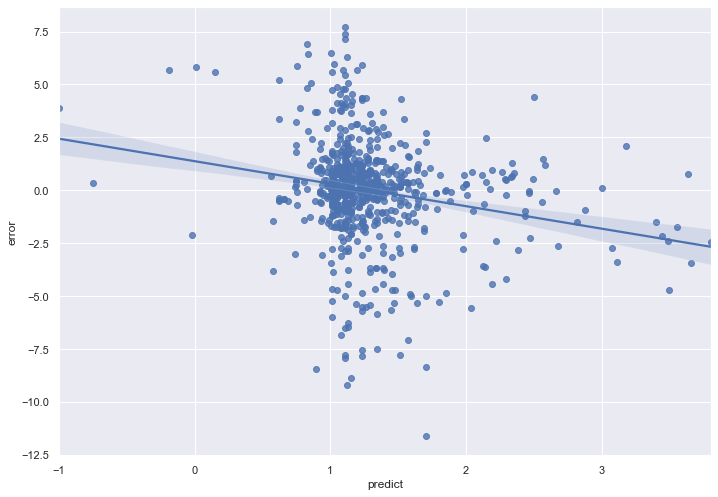

In [246]:
lm = pd.DataFrame({'predict': rf_model.predict(X), 'true':Y})
lm['error'] = lm['predict'] - lm['true']
plot_df = lm.copy().sort_values(['error']).reset_index()
print('R2', r2_score(lm['true'],lm['predict']),
      '\nRMSE', mean_squared_error(lm['true'],lm['predict'],squared=False),
      '\nMAE', mean_absolute_error(lm['true'],lm['predict']))
sns.regplot(x = 'predict' , y = 'error', data = plot_df)

<AxesSubplot:>

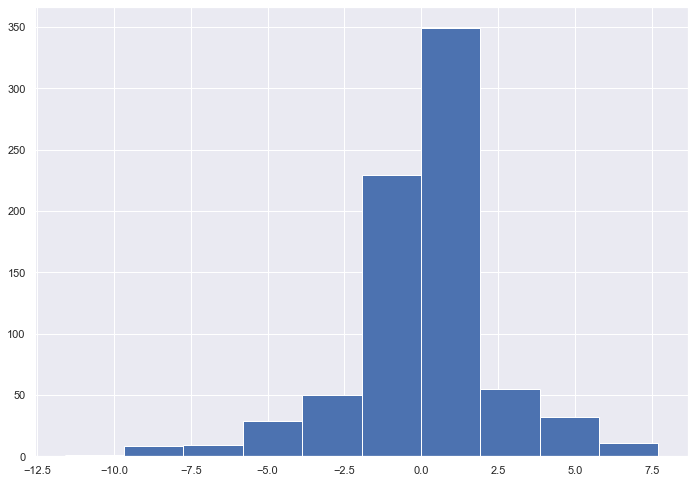

In [247]:
plot_df.error.hist()

<AxesSubplot:>

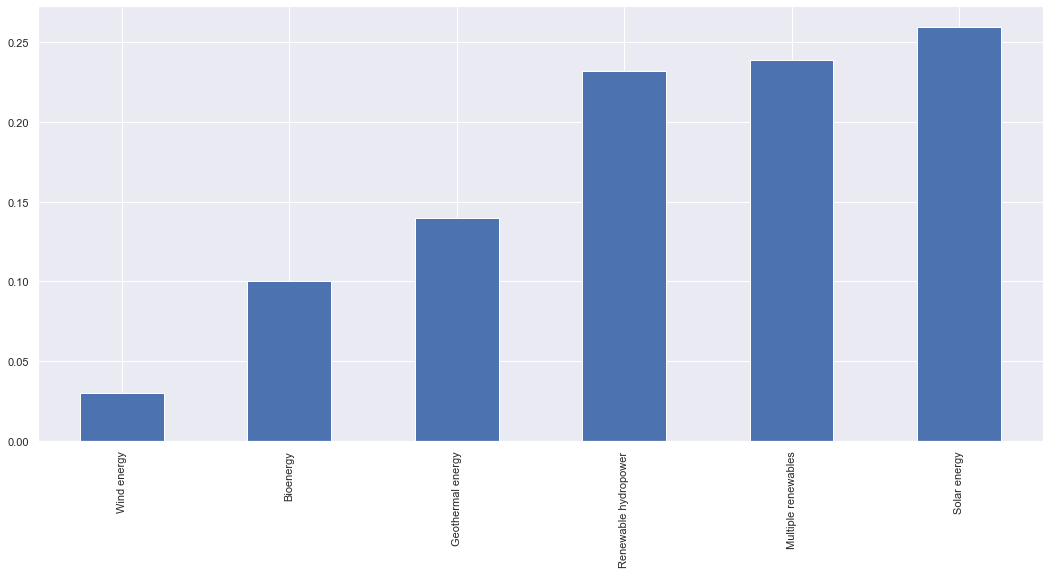

In [248]:
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values().plot.bar(figsize=(18,8))

# Model Deployment
#### Get Variable Boundaries from RF Model

In [39]:
def tree_to_pseudo(tree, feature_names, tree_id):

    '''
    Outputs a decision tree model as if/then pseudocode
    
    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as pseudocode
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    samples = tree.tree_.n_node_samples
    
    G = nx.Graph()
    G.add_nodes_from(range(len(value)))
    
    leaves = []

    def recurse(left, right, threshold, features, node, depth=0):
        if (threshold[node] != -2):
            if left[node] != -1:
                G.add_edge(node, left[node])
                d = {(node, left[node]):{'feature':features[node], 'sign':"<=", 'threshold':threshold[node],'depth':depth}}
                nx.set_edge_attributes(G, d)
                recurse (left, right, threshold, features, left[node], depth+1)
                if right[node] != -1:
                    G.add_edge(node, right[node])
                    d = {(node, right[node]):{'feature':features[node], 'sign':">", 'threshold':threshold[node],'depth':depth}}
                    nx.set_edge_attributes(G, d)
                    recurse (left, right, threshold, features, right[node], depth+1)
        else:
            leaves.append(node)
    recurse(left, right, threshold, features, 0)
    
    l = []
    p = []
    for leaf in leaves:
        path = nx.shortest_path(G, 0, leaf)
        leaf_id = str(tree_id)+str(leaf)
        l.append({'leaf_id': leaf_id, 'tree_id':tree_id, 'value':value[leaf][0][0]})
        for i in range(len(path)-1):
            e = G[path[i]][path[i+1]]
            p_id = leaf_id + str(i)
            p.append({'path_id':p_id, 'leaf_id':leaf_id,
                      'feature':e['feature'], 'sign':e['sign'],
                      'threshold':e['threshold'], 'depth':e['depth']
                     })
        
    
    return pd.DataFrame(l), pd.DataFrame(p)

In [40]:
# leaf_df = pd.DataFrame(columns=['leaf_id','tree_id','value'])
leaf_df = pd.DataFrame()
rules_df = pd.DataFrame()
for tree_id in range(len(rf_model.estimators_)):
    l, r = tree_to_pseudo(rf_model.estimators_[tree_id], X.columns, tree_id)
    leaf_df = leaf_df.append(l)
    rules_df = rules_df.append(r)
rules_df

,path_id,leaf_id,feature,sign,threshold,depth
0,070,07,Bioenergy,<=,2.171901,0
1,071,07,Solar energy,<=,-0.789945,1
2,072,07,Multiple renewables,<=,0.768871,2
3,073,07,Wind energy,<=,0.331103,3
4,074,07,Solar energy,<=,-0.801699,4
...,...,...,...,...,...,...
31,14142,1414,Multiple renewables,<=,1.152573,2
32,14150,1415,Bioenergy,<=,1.425838,0
33,14151,1415,Multiple renewables,>,0.659120,1
34,14152,1415,Multiple renewables,>,1.152573,2


#### Linear Programming

In [41]:
linear_model.coef_

array([-0.00993351,  0.01798305,  0.02747563,  0.03582645,  0.03412771,
        0.04193465, -0.01106827])

In [42]:
X.columns.to_list()

['Multiple renewables',
 'Solar energy',
 'Renewable hydropower',
 'Bioenergy',
 'Wind energy',
 'Geothermal energy',
 'Marine energy']

In [87]:
def optimize_investment(target_raw):
    
    target = y_transformer.transform(np.array(target_raw).reshape(1,-1))[0][0]
    
    picked_df = pd.DataFrame()
    for i in range(len(rf_model.estimators_)):
        filt = leaf_df[leaf_df.tree_id == i].copy()
        filt['selisih'] = (filt.value - target).abs()
        leaf = filt[filt.selisih == filt.selisih.min()]['leaf_id'].values[0]

        picked_df = picked_df.append(rules_df[rules_df.leaf_id == leaf])

    lt = picked_df[picked_df.sign == '<='].sort_values(['feature','depth','threshold']).drop_duplicates(['feature'])
    gt = picked_df[picked_df.sign == '>'].sort_values(['feature','depth','threshold'], ascending=[True,True,False]).drop_duplicates(['feature'])
    picked_df = lt.append(gt).sort_values(['feature'])

    # linear programming
    # Create the model
    prob = LpProblem(name="Renewable_Investment",sense=LpMinimize)
    # Initialize the decision variables
    var = []
    var_result = {}
    
    for col in X.columns:
        rules = picked_df[picked_df.feature == col]
        low = rules[rules.sign == '>'].threshold.values[0] if rules[rules.sign == '>'].threshold.values.shape[0] != 0 else None
        up = rules[rules.sign == '<='].threshold.values[0] if rules[rules.sign == '<='].threshold.values.shape[0] != 0 else None
        if up is not None and low is not None:
            if up < low:
                if rules[rules.sign == '>'].depth.values[0] < rules[rules.sign == '<='].depth.values[0]:
                    up = None
                else:
                    low = None
        new_var = LpVariable(name=col, lowBound=low, upBound=up)
        var.append(new_var)
    # Add the objective function to the model
    prob += linear_model.intercept_ + \
            linear_model.coef_[0]*var[0] + \
            linear_model.coef_[1]*var[1] + \
            linear_model.coef_[2]*var[2] + \
            linear_model.coef_[3]*var[3] + \
            linear_model.coef_[4]*var[4] + \
            linear_model.coef_[5]*var[5] + \
            linear_model.coef_[6]*var[6] + \
            np.sum(np.abs(np.append(linear_model.intercept_, linear_model.coef_)))*linear_model.get_params()['alpha'] + \
            (-target)
    status = prob.solve()
    
    np_result = []
    for i in range(len(var)):
        np_result.append(pulp.value(var[i]))
        
    # transform back the X
    var_result = x_transformer.inverse_transform(np.array(np_result).reshape(1,-1))
    return (status, var_result)

In [88]:
X.columns

Index(['Multiple renewables', 'Solar energy', 'Renewable hydropower',
       'Bioenergy', 'Wind energy', 'Geothermal energy', 'Marine energy'],
      dtype='object')

In [94]:
optimazed = optimize_investment(5)
print(optimazed)
prediction = linear_model.predict(x_transformer.transform(optimazed[1].reshape(1,-1)))
y_transformer.inverse_transform(prediction.reshape(1, -1))

(-2, array([[5.30804147e+01, 4.92505282e-02, 6.54111037e+01, 2.81170436e-01,
        1.87754283e+02, 1.47474112e-02, 4.24633828e-07]]))


array([[1.71147069]])

In [83]:
pulp.getSolver('CPLEX_CMD', timeLimit=10)

In [69]:
a = optimazed[1][0]
a.sort()
a

array([4.24633828e-07, 1.47474112e-02, 4.92505282e-02, 2.81170436e-01,
       5.30804147e+01, 6.54111037e+01, 1.87754283e+02])

# Cara alternatif

In [554]:
import random
rand_df=pd.DataFrame()
for col in X.columns:
    rand_df[col]=X[col].sample(1000000, replace=True).reset_index(drop=True)+((random.random()-0.5)/100)
    maxs = X[col].max()
    mins = X[col].min()
    rand_df.loc[rand_df[col] > maxs, col] = maxs
    rand_df.loc[rand_df[col] < mins, col] = mins
    
rand_df = rand_df.drop_duplicates()
rand_df.shape

(729197, 6)

In [555]:
mesh_df = pd.DataFrame(x_transformer.inverse_transform(rand_df), columns = rand_df.columns)
mesh_df['prediction'] = rf_model.predict(rand_df)
mesh_df

C:\Users\ade.satya\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3176: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


,Multiple renewables,Solar energy,Renewable hydropower,Bioenergy,Wind energy,Geothermal energy,prediction
0,0.000000,0.002559,0.418027,0.000280,0.0,0.000048,1.218103
1,0.831255,6.311731,0.001514,0.000280,0.0,0.000048,1.225148
2,0.000000,0.002559,0.001514,0.705005,0.0,0.000048,1.192434
3,471.754777,0.017039,109.046247,0.000280,0.0,0.000048,1.175679
4,0.162320,70.589265,0.481655,0.000280,0.0,0.000048,1.477855
...,...,...,...,...,...,...,...
729192,23.255663,12.145689,0.001514,0.000280,0.0,0.000048,1.017962
729193,18.483513,0.233804,0.001514,0.000280,0.0,0.000048,1.046450
729194,24.869248,138.704989,0.001514,0.003812,0.0,0.000048,1.015086
729195,0.000000,0.002559,0.764314,0.020505,0.0,0.000048,1.132237


In [556]:
for col in mesh_df.columns:
    mesh_df.loc[mesh_df[col] == np.inf, col] = finance_df.loc[finance_df.Technology == col, 'Amount (2020 USD million)'].max()
    mesh_df.loc[mesh_df[col].abs() < 10**-12, col] = 0
    
mesh_df = mesh_df.iloc[np.where(mesh_df[mesh_df.columns[:-1]].gt(0).any(1))]
mesh_df = mesh_df.drop_duplicates(subset=mesh_df.columns[:-1]).reset_index(drop=True)
mesh_df.shape

(729197, 7)

<AxesSubplot:>

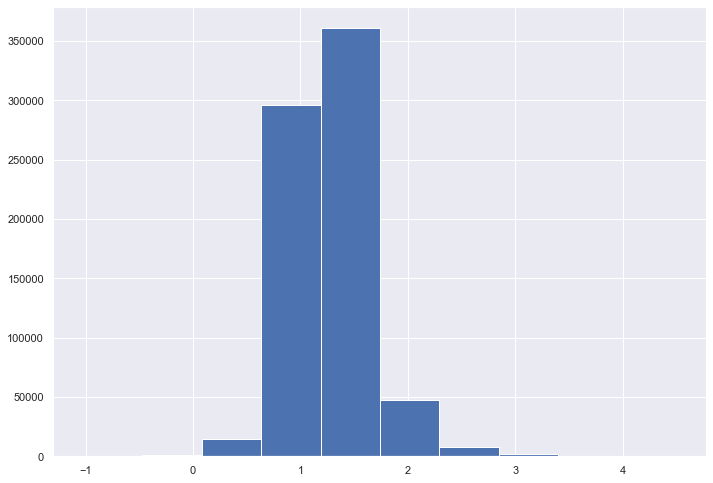

In [557]:
mesh_df.prediction.hist()

In [558]:
mesh_df.describe()

,Multiple renewables,Solar energy,Renewable hydropower,Bioenergy,Wind energy,Geothermal energy,prediction
count,729197.000000,729197.000000,729197.000000,729197.000000,729197.000000,729197.000000,729197.000000
mean,19.455247,26.576255,142.728314,5.132142,0.877196,10.687177,1.276385
std,49.935057,109.218162,546.736097,21.966330,2.824550,66.101956,0.339078
min,0.000000,0.002559,0.001514,0.000280,0.000000,0.000048,-1.022922
25%,0.025748,0.003445,0.001514,0.000280,0.000000,0.000048,1.087676
50%,0.942187,0.227594,0.771370,0.000280,0.000000,0.000048,1.234899
75%,13.291628,8.803852,37.316988,0.027622,0.000000,0.000048,1.431762
max,497.929212,1131.172933,6054.273759,102.976124,11.531967,420.073119,4.501790


In [611]:
# target = 3
sisa_index = []

for target in range(-102,451):
    target /= 100
    delta = (mesh_df.prediction - target).abs().nsmallest(5)
    sisa_index.append(delta.index.to_list())
final_df = mesh_df.iloc[list(set([i for j in sisa_index for i in j ]))]

In [619]:
def get_optimize(target):
    delta = (final_df.prediction - target).abs().nsmallest(5)
    opt = mesh_df.iloc[delta.index.to_list()]
    return opt

result = get_optimize(2.1)

# print(rf_model.predict(x_transformer.transform(result.values.reshape(1,-1))))
result

,Multiple renewables,Solar energy,Renewable hydropower,Bioenergy,Wind energy,Geothermal energy,prediction
311612,92.130940,31.929334,748.62705,0.00028,0.053108,0.000048,2.100081
289601,99.076254,42.642029,701.20606,0.00028,0.000000,0.000048,2.100081
233529,84.331907,36.212317,748.62705,0.00028,0.000000,0.000048,2.100081
496631,72.700891,42.650705,701.20606,0.00028,0.000000,0.000048,2.100081
89551,74.056007,37.685543,925.34628,0.00028,0.000000,0.000048,2.100081


In [593]:
final_df.to_csv('reference_df.csv')
    
# Open a file and use dump()
with open('rf_model.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(rf_model, file)

In [601]:
pd.read_excel('https://github.com/anitarohmawati/GATOTKACA/blob/ANITA/mydata.xlsx?raw=true')

,tahun,profit,cost,revenue
0,2005,100,200,300
1,2006,200,200,400
2,2007,350,200,550


In [620]:
final_df.to_csv('reference_df.csv')